In [6]:
import sys
sys.path.append('../')
from utils import BrainGraphDataset, project_root
from models import VAE
import torch
import os
from torch.utils.data import random_split
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# set the random seed for reproducibility
torch.manual_seed(0)

# define the hyperparameters
input_dim = 4950  # size of the graph adjacency matrix
hidden_dim = 256
latent_dim = 64
lr = 1e-3
batch_size = 64
num_epochs = 100

annotations = 'annotations.csv'
dataroot = 'fc_matrices/hcp_100_ica/'
root = project_root()

dataroot = 'fc_matrices/psilo_ica_100_before/'
psilo_dataset = BrainGraphDataset(img_dir=os.path.join(root, dataroot),
                            annotations_file=os.path.join(root, annotations),
                            transform=None, extra_data=None, setting='upper_triangular')

train_prop = 0.8

# split the psilo dataset into training and validation sets

num_psilo_samples = len(psilo_dataset)
psilo_train_size = int(train_prop * num_psilo_samples)
psilo_val_size = num_psilo_samples - psilo_train_size
train_set, val_set = random_split(psilo_dataset, [psilo_train_size, psilo_val_size])

# Create the mixed class loader
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=0, pin_memory=True)

dropout = 0.0

best_val_loss = float('inf')  # set to infinity to start
best_model_state = None
train_losses = []
val_losses = []
model = VAE(input_dim, [128] * 2, latent_dim, dropout=dropout).to(device)  # move model to device
model.load_state_dict(torch.load(os.path.join(root, 'vae_weights/vae_dropout_hcp_0.pt'), map_location=device))
optimizer = optim.Adam(model.parameters(), lr=lr)
    
for epoch in tqdm(range(num_epochs)):
    train_loss = 0.0
    val_loss = 0.0

    # training
    model.train()
    for batch_idx, (graph, _) in enumerate(train_loader):
        graph = graph.to(device)
        optimizer.zero_grad()

        recon, mu, logvar, _ = model(graph.view(-1, input_dim))
        mse_loss, gmm_loss, l2_reg = model.loss(recon, graph.view(-1, input_dim), mu, logvar, n_components=3)
        loss = mse_loss + gmm_loss + l2_reg
        loss.backward()
        optimizer.step()
        train_loss += mse_loss.item()

    # validation
    model.eval()
    with torch.no_grad():
        for batch_idx, (graph, _) in enumerate(val_loader):
            graph = graph.to(device)
            recon, mu, logvar, _ = model(graph.view(-1, input_dim))
            mse_loss, gmm_loss, l2_reg = model.loss(recon, graph.view(-1, input_dim), mu, logvar, n_components=3)
            
            val_loss += mse_loss.item()
            
    train_losses.append(train_loss/len(train_set))
    val_losses.append(val_loss/len(val_set))
    
    # save the model if the validation loss is at its minimum
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        best_model_state = copy.deepcopy(model.state_dict())

    # print the losses

    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}\n')

# save the best model for this configuration
torch.save(best_model_state, os.path.join(root, f'vae_weights/fine_tune_best.pt'))

# make loss curves
loss_curves = {}
loss_curves['train_curve'] = train_losses
loss_curves['val_curve'] = val_losses

import json
# save the loss curves to a file
with open(os.path.join(root, 'loss_curves', 'loss_curve_fine_tune_reg.json'), "w") as f:
    json.dump(loss_curves, f)

cpu


  5%|▌         | 5/100 [00:06<02:12,  1.39s/it]

Epoch 5/100 - Train Loss: 178.7388 - Val Loss: 161.2365



 10%|█         | 10/100 [00:13<02:04,  1.39s/it]

Epoch 10/100 - Train Loss: 147.7025 - Val Loss: 148.6290



 15%|█▌        | 15/100 [00:21<02:01,  1.43s/it]

Epoch 15/100 - Train Loss: 134.2846 - Val Loss: 147.2786



 20%|██        | 20/100 [00:28<01:55,  1.44s/it]

Epoch 20/100 - Train Loss: 124.6281 - Val Loss: 146.0812



 25%|██▌       | 25/100 [00:35<01:45,  1.41s/it]

Epoch 25/100 - Train Loss: 115.8554 - Val Loss: 145.1946



 30%|███       | 30/100 [00:42<01:37,  1.40s/it]

Epoch 30/100 - Train Loss: 107.8815 - Val Loss: 144.9527



 35%|███▌      | 35/100 [00:49<01:30,  1.39s/it]

Epoch 35/100 - Train Loss: 100.3786 - Val Loss: 145.1951



 40%|████      | 40/100 [00:56<01:23,  1.39s/it]

Epoch 40/100 - Train Loss: 93.1242 - Val Loss: 146.1317



 45%|████▌     | 45/100 [01:02<01:14,  1.36s/it]

Epoch 45/100 - Train Loss: 86.0587 - Val Loss: 147.4066



 50%|█████     | 50/100 [01:09<01:07,  1.35s/it]

Epoch 50/100 - Train Loss: 79.1618 - Val Loss: 148.7383



 55%|█████▌    | 55/100 [01:16<01:00,  1.35s/it]

Epoch 55/100 - Train Loss: 72.4738 - Val Loss: 150.1966



 60%|██████    | 60/100 [01:23<00:53,  1.35s/it]

Epoch 60/100 - Train Loss: 66.0194 - Val Loss: 151.3012



 65%|██████▌   | 65/100 [01:30<00:47,  1.37s/it]

Epoch 65/100 - Train Loss: 59.8136 - Val Loss: 153.0342



 70%|███████   | 70/100 [01:36<00:41,  1.37s/it]

Epoch 70/100 - Train Loss: 53.9118 - Val Loss: 154.6733



 75%|███████▌  | 75/100 [01:43<00:34,  1.37s/it]

Epoch 75/100 - Train Loss: 48.3104 - Val Loss: 155.8921



 80%|████████  | 80/100 [01:50<00:27,  1.38s/it]

Epoch 80/100 - Train Loss: 42.8122 - Val Loss: 157.6920



 85%|████████▌ | 85/100 [01:57<00:20,  1.38s/it]

Epoch 85/100 - Train Loss: 37.8188 - Val Loss: 159.8247



 90%|█████████ | 90/100 [02:04<00:13,  1.38s/it]

Epoch 90/100 - Train Loss: 33.1293 - Val Loss: 160.8673



 95%|█████████▌| 95/100 [02:11<00:06,  1.39s/it]

Epoch 95/100 - Train Loss: 28.6640 - Val Loss: 163.0301



100%|██████████| 100/100 [02:18<00:00,  1.38s/it]

Epoch 100/100 - Train Loss: 24.6146 - Val Loss: 164.7248



In [15]:
import json
import matplotlib.pyplot as plt

# load in the loss curves from file
with open(os.path.join(root, "vae_weights/loss_curve_fine_tune_reg.json"), "r") as f:
    loss_curves = json.load(f)

val_losses = loss_curves['val_curve']
# plot the validation loss curves for each number of GMM components
plt.figure(figsize=(8, 6))

epochs = range(1, len(val_losses) + 1)
plt.plot(epochs, val_losses, label=f"Val")

# add labels and legend
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Curves")
plt.legend()
plt.ylim((200, 375))

# show the plot
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/rds/general/user/ljn19/home/big/container/psilocybrain/vae_weights/loss_curve_fine_tune_reg.json'

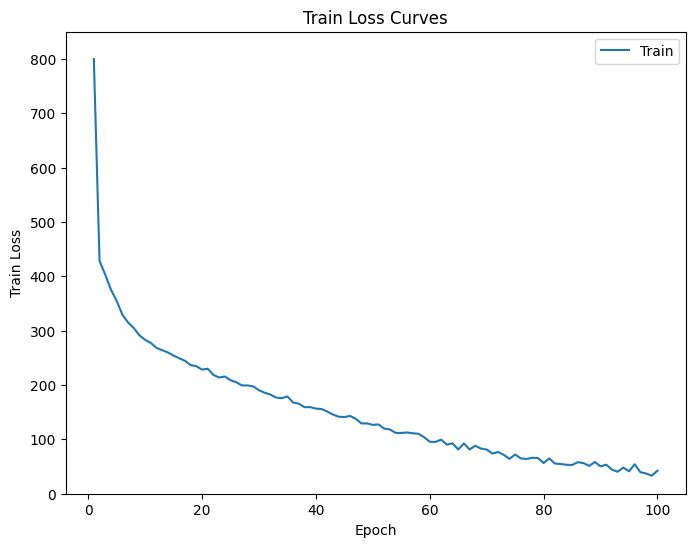

In [31]:
import json
import matplotlib.pyplot as plt

# load in the loss curves from file
with open("loss_curve_fine_tune_reg.json", "r") as f:
    loss_curves = json.load(f)

train_losses = loss_curves['train_curve']
# plot the validation loss curves for each number of GMM components
plt.figure(figsize=(8, 6))

epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label="Train")

# add labels and legend
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Train Loss Curves")
plt.legend()
plt.ylim((0, 850))

# show the plot
plt.show()

In [5]:
# load in the models and get the validation loss for each
models = []
val_losses = []
l2_strength = 0.01
dropout = 0.05

# instantiate the model
# model = VAEReg(input_dim, hidden_dim, latent_dim, device=device).to(device)

# load the weights
model.load_state_dict(torch.load(os.path.join(root, f'vae_weights/fine_tune_best.pt'), map_location=device))

# set the model to evaluation mode
model.eval()

# calculate the validation loss
val_loss = 0.0
with torch.no_grad():
    for batch_idx, (graph, _) in enumerate(val_loader):
        graph = graph.to(device)
        recon, mu, logvar, _ = model(graph.view(-1, input_dim))
        mse_loss, gmm_loss, l2_reg = model.loss(recon, graph.view(-1, input_dim), mu, logvar, n_components=3)

        val_loss += mse_loss.item()
val_loss /= len(val_set)

# print the validation loss for each model
print(f'Validation Loss = {val_loss:.4f}')

Validation Loss = 164.7246


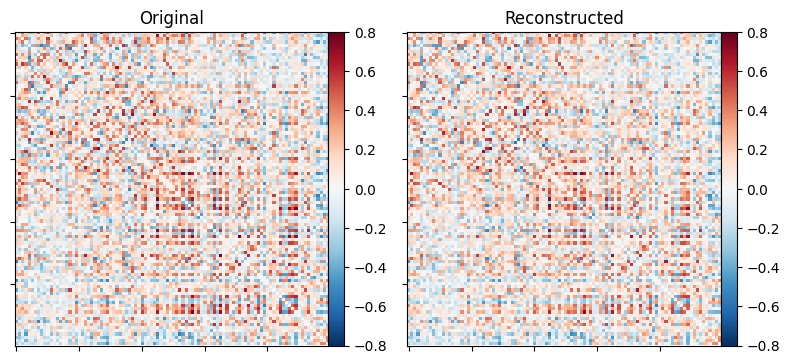

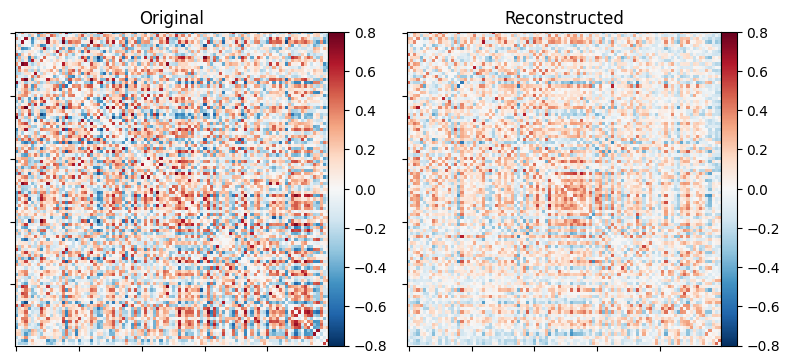

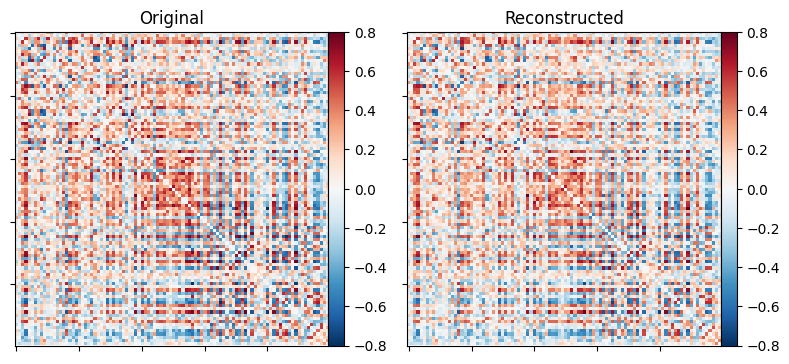

In [33]:
import matplotlib.pyplot as plt
from nilearn import plotting

psilo_loader = DataLoader(psilo_dataset, batch_size=batch_size, num_workers=0, pin_memory=True)
hcp_loader = DataLoader(hcp_dataset, batch_size=batch_size, num_workers=0, pin_memory=True)

# select a batch from the validation data loader
graph, _ = next(iter(psilo_loader))

graph = graph.to(device)
# pass the batch through the trained model to obtain the reconstructed output
recon, _, _, _ = model(graph.view(-1, input_dim))

# reshape the output to a 100x100 matrix (assuming the input_dim is 100x100)
recon = recon.view(-1, 100, 100)

for i in range(3):
    # plot the original and reconstructed matrices for the first sample in the batch
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    plotting.plot_matrix(graph[i].cpu(), colorbar=True, vmax=0.8, vmin=-0.8, axes=ax1)
    ax1.set_title('Original')
    plotting.plot_matrix(recon[i].cpu().detach(), colorbar=True, vmax=0.8, vmin=-0.8, axes=ax2)
    ax2.set_title('Reconstructed')
    plt.show()